# Estimating SWE

This is an experiment to try calculating SWE based on the phase change. I won't really apply many corrections or filtering to these. 


- Load raw SLCs 
- Get angle (phase) from SLCs 
- Difference the angle between the pairs of SLCs 
- Plot (hope to see fringes!)

I'll actually want to do this with GAMMA, I think. Really just to see for this project, anyways. 

In [39]:
import numpy as np
from pathlib import Path
from datetime import datetime
from time import time
import pandas as pd
import xarray as xr
import rioxarray as rxa
import matplotlib.pyplot as plt
import math

# uavsar code
from uavsar_pytools.convert.tiff_conversion import read_annotation


In [41]:
# working in radar coordinates for now
data_dir = '../data/snowex_lowman/slcs_geocoded/'

# use just 05208 flight 2021 data for now
in_dir = Path(data_dir)
slcs_05208 = sorted(list(in_dir.glob('*05208_21*geoslc.tif')))
# anns_05208 = sorted(list(in_dir.glob('*05208_21*.ann')))

In [46]:
# for the non-geocoded SLCs
# d = read_annotation(anns_05208[0])
# d = pd.DataFrame(d).T
# rows, cols = d.loc['slc_2_2x8 rows', 'value'], d.loc['slc_2_2x8 columns', 'value']
# print(rows, cols)
# stack = np.zeros((len(slcs_05208), rows, cols), '<c8')
# dates = []
# for i, (slc, ann) in enumerate(zip(slcs_05208, anns_05208, strict = True)):
#     print(slc)
#     d = read_annotation(ann)
#     d = pd.DataFrame(d).T
#     timestamp = d.loc['start time of acquisition', 'value']

#     stack[i, :, :] = np.fromfile(slc, '<c8').reshape(rows, cols)
#     dates.append(timestamp)

stack = []
# for geocoded SLCs
for slc in slcs_05208:
    print(str(slc))
    xarr = rxa.open_rasterio(str(slc))  # shape: (2, rows, cols)

    # Combine bands into complex array
    real = xarr.sel(band=1)
    imag = xarr.sel(band=2)
    complex_data = real.values + 1j * imag.values

    # Create a new DataArray with complex dtype, preserving coords and attrs
    complex_xarr = real.copy(data=complex_data)

    stack.append(complex_xarr)


../data/snowex_lowman/slcs_geocoded/lowman_05208_21009_005_210203_L090VV_01_BU_s2_2x8_geoslc.tif
../data/snowex_lowman/slcs_geocoded/lowman_05208_21012_004_210210_L090VV_01_BU_s2_2x8_geoslc.tif
../data/snowex_lowman/slcs_geocoded/lowman_05208_21015_009_210303_L090VV_01_BU_s2_2x8_geoslc.tif
../data/snowex_lowman/slcs_geocoded/lowman_05208_21017_019_210310_L090VV_01_BU_s2_2x8_geoslc.tif
../data/snowex_lowman/slcs_geocoded/lowman_05208_21019_019_210316_L090VV_01_BU_s2_2x8_geoslc.tif
../data/snowex_lowman/slcs_geocoded/lowman_05208_21021_007_210322_L090VV_01_BU_s2_2x8_geoslc.tif


In [53]:
print(len(stack))
print(stack[0].shape)  # Should be (rows, cols)
print(stack[0])


6
(8333, 4896)
<xarray.DataArray (y: 8333, x: 4896)> Size: 326MB
array([[nan+0.j, nan+0.j, nan+0.j, ..., nan+0.j, nan+0.j, nan+0.j],
       [nan+0.j, nan+0.j, nan+0.j, ..., nan+0.j, nan+0.j, nan+0.j],
       [nan+0.j, nan+0.j, nan+0.j, ..., nan+0.j, nan+0.j, nan+0.j],
       ...,
       [nan+0.j, nan+0.j, nan+0.j, ..., nan+0.j, nan+0.j, nan+0.j],
       [nan+0.j, nan+0.j, nan+0.j, ..., nan+0.j, nan+0.j, nan+0.j],
       [nan+0.j, nan+0.j, nan+0.j, ..., nan+0.j, nan+0.j, nan+0.j]],
      shape=(8333, 4896), dtype=complex64)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 39kB -115.9 -115.9 -115.9 ... -115.4 -115.4 -115.4
  * y            (y) float64 67kB 44.19 44.19 44.19 44.19 ... 43.81 43.81 43.81
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0


To calculate phase change, we use np.angle to get the phase from the SLC which represents the phase and amplitude in complex number form. 

Once we have the angle (phase), we subtract phase 2 

In [57]:
n_choose_2 = math.comb(len(stack), 2)
print(f"Number of interferograms: {math.comb(len(stack), 2)}")

Number of interferograms: 15


In [67]:
counter = 0
# print((n_choose_2, stack[0].shape[0]))
stack_intf = []

# print(stack_intf.shape)
# calculate phase change 
for i in range(len(stack)) : 
    for j in range(i, len(stack)) : 
        if (i == j) : 
            continue
        phase1 = np.angle(stack[i])
        phase2 = np.angle(stack[j])

        # print(phase1)
        # print(phase2)

        phase_change = stack[i].copy(data = (phase2 - phase1))

        stack_intf.append(phase_change)
        counter += 1


In [68]:
print(stack_intf[0])

<xarray.DataArray (y: 8333, x: 4896)> Size: 163MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(8333, 4896), dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 39kB -115.9 -115.9 -115.9 ... -115.4 -115.4 -115.4
  * y            (y) float64 67kB 44.19 44.19 44.19 44.19 ... 43.81 43.81 43.81
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0


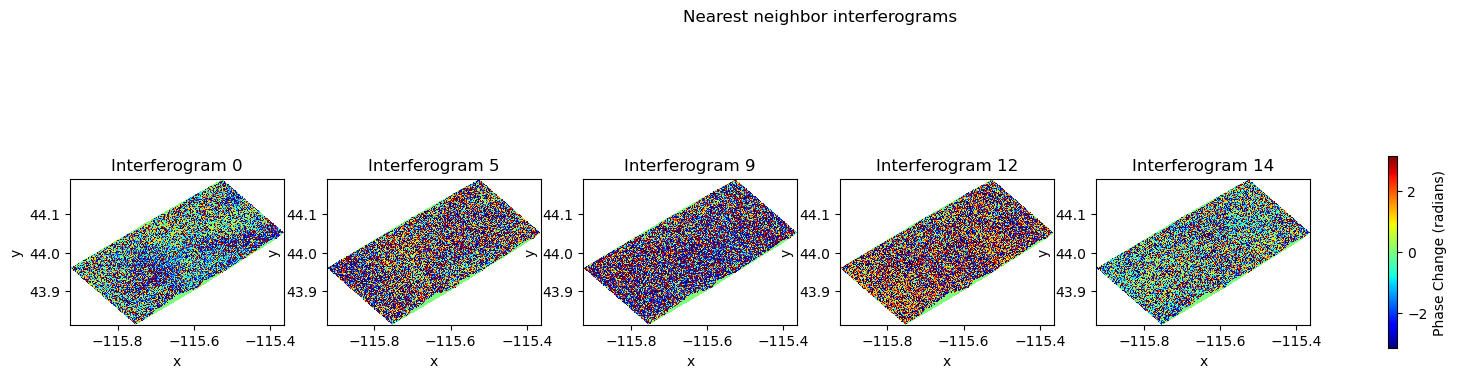

In [78]:
# downsample nearest neighbors to be able to plot them side-by-side 
indices = [0, 5, 9, 12, 14]

fig, axes = plt.subplots(1, len(indices), figsize=(20, 5))

for idx in indices :
    phase_data = stack_intf[idx]

    # downsample by factor of 10 for plotting
    phase_data_ds = phase_data.isel(x=slice(None, None, 10), y=slice(None, None, 10))
    ax = axes[indices.index(idx)]
    im = phase_data_ds.plot(ax=ax, cmap='jet', vmin=-np.pi, vmax=np.pi, robust=True, add_colorbar=False)
    ax.set_title(f'Interferogram {idx}')
    ax.set_aspect('equal')  # Ensures equal degree dimensions

fig.suptitle('Nearest neighbor interferograms')
fig.colorbar(im, ax=axes, shrink=0.5, label='Phase Change (radians)')
# plt.tight_layout()
plt.show()

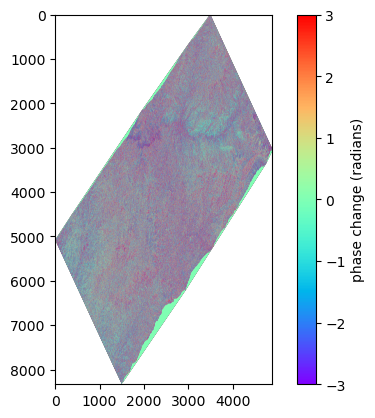

In [79]:
fig = plt.imshow(stack_intf[14], cmap='rainbow', vmin = -3, vmax = 3)
plt.colorbar(label = 'phase change (radians)')
plt.show()

I don't see any fringes in my first go at plots. The phase difference should in theory be a plot with fringes showing wrapped phase change. 
